<a href="https://colab.research.google.com/github/BaoNguyen151654/MLOPS_FRAUD_DETECTION/blob/main/XGBmodel_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
import pickle

In [3]:
df = pd.read_csv('/content/fraudTrain.csv', index_col='Unnamed: 0')
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
df['is_fraud'].value_counts()

,count
is_fraud,
0,1289169
1,7506


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

In [6]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

In [7]:
df = df.sort_values(['cc_num', 'trans_date_trans_time'])

In [8]:
df['category'].unique()

array(['misc_net', 'gas_transport', 'kids_pets', 'home', 'shopping_net',
       'food_dining', 'personal_care', 'grocery_pos', 'entertainment',
       'shopping_pos', 'misc_pos', 'travel', 'health_fitness',
       'grocery_net'], dtype=object)

In [9]:
cols = [
    'trans_date_trans_time', 'category',
    'cc_num',
    'merchant',
    'lat', 'long',
    'merch_lat', 'merch_long',
    'amt', 'is_fraud'
]
df = df[cols].copy()

In [10]:
category_mapping = {
    'misc_net': 0,
    'grocery_pos': 1,
    'entertainment': 2,
    'gas_transport': 3,
    'misc_pos': 4,
    'grocery_net': 5,
    'shopping_net': 6,
    'shopping_pos': 7,
    'food_dining': 8,
    'personal_care': 9,
    'health_fitness': 10,
    'travel': 11,
    'kids_pets': 12,
    'home': 13
}
df['category'] = df['category'].map(category_mapping)

In [11]:
df['time_last_trans'] = (
    df.groupby('cc_num')['trans_date_trans_time']
      .diff()
      .dt.total_seconds()
      .fillna(0)
)

In [12]:
geo_cols = ['lat', 'long', 'merch_lat', 'merch_long','amt']
for col in geo_cols:
    df[col + '_pre'] = df.groupby('cc_num')[col].shift(1)

In [13]:
df = df.fillna(0)

In [14]:
df['merchant_pre'] = df.groupby('cc_num')['merchant'].shift(1)
df['pre_mer'] = (df['merchant'] == df['merchant_pre']).astype(int)

In [15]:
df = df.drop('merchant_pre', axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 1017 to 1296427
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   category               1296675 non-null  int64         
 2   cc_num                 1296675 non-null  int64         
 3   merchant               1296675 non-null  object        
 4   lat                    1296675 non-null  float64       
 5   long                   1296675 non-null  float64       
 6   merch_lat              1296675 non-null  float64       
 7   merch_long             1296675 non-null  float64       
 8   amt                    1296675 non-null  float64       
 9   is_fraud               1296675 non-null  int64         
 10  time_last_trans        1296675 non-null  float64       
 11  lat_pre                1296675 non-null  float64       
 12  long_pre               1296675

In [17]:
exclude_cols = ['is_fraud', 'cc_num', 'merchant', 'trans_date_trans_time']
X = df.drop(columns=exclude_cols)
y = df['is_fraud']

In [18]:
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=172,
    max_delta_step=1,
    eval_metric="aucpr",
    tree_method="hist"
)

In [19]:
xgb_model.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=6,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [21]:
test = pd.read_csv('/content/fraudTest.csv', index_col='Unnamed: 0')
test.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [22]:
test['cc_num'].nunique()

924

In [23]:
test['trans_date_trans_time'] = pd.to_datetime(test['trans_date_trans_time'])
test = test.sort_values(['cc_num', 'trans_date_trans_time'])
test = test[cols].copy()
test['category'] = test['category'].map(category_mapping)
test['time_last_trans'] = (
    test.groupby('cc_num')['trans_date_trans_time']
      .diff()
      .dt.total_seconds()
      .fillna(0)
)
for col in geo_cols:
    test[col + '_pre'] = test.groupby('cc_num')[col].shift(1)
test = test.fillna(0)
test['merchant_pre'] = test.groupby('cc_num')['merchant'].shift(1)
test['pre_mer'] = (test['merchant'] == test['merchant_pre']).astype(int)
test = test.drop('merchant_pre', axis=1)

In [24]:
test.head()

,trans_date_trans_time,category,cc_num,merchant,lat,long,merch_lat,merch_long,amt,is_fraud,time_last_trans,lat_pre,long_pre,merch_lat_pre,merch_long_pre,amt_pre,pre_mer
157,2020-06-21 13:05:42,13,60416207185,fraud_Kutch-Ferry,43.0048,-108.8964,42.945526,-108.530901,124.66,0,0.0,0.0000,0.0000,0.000000,0.000000,0.00,0
741,2020-06-21 16:25:36,4,60416207185,fraud_Halvorson Group,43.0048,-108.8964,42.193130,-108.682054,78.52,0,11994.0,43.0048,-108.8964,42.945526,-108.530901,124.66,0
3047,2020-06-22 07:58:33,3,60416207185,fraud_Conroy-Cruickshank,43.0048,-108.8964,43.932724,-109.699794,65.25,0,55977.0,43.0048,-108.8964,42.193130,-108.682054,78.52,0
4351,2020-06-22 15:32:31,12,60416207185,fraud_Larkin Ltd,43.0048,-108.8964,43.546064,-109.212939,87.74,0,27238.0,43.0048,-108.8964,43.932724,-109.699794,65.25,0
7695,2020-06-23 12:28:54,9,60416207185,fraud_Leffler-Goldner,43.0048,-108.8964,42.876538,-109.333220,148.02,0,75383.0,43.0048,-108.8964,43.546064,-109.212939,87.74,0


In [25]:
X_test = test.drop(columns=exclude_cols)
y_test = test['is_fraud']

In [26]:
y_pred = xgb_model.predict(X_test)

In [27]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.29      0.94      0.44      2145

    accuracy                           0.99    555719
   macro avg       0.65      0.97      0.72    555719
weighted avg       1.00      0.99      0.99    555719



<Figure size 600x600 with 0 Axes>

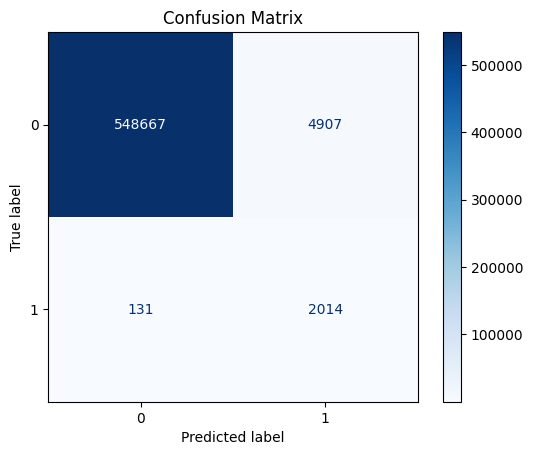

In [28]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [29]:
baseline_means = X.mean().to_dict()

In [30]:
artifact = {
    'model': xgb_model,
    'baseline_means': baseline_means
}
with open('model.pkl', 'wb') as f:
    pickle.dump(artifact, f)

In [31]:
baseline_means

{'category': 6.527678099755143,
 'lat': 38.53762161489964,
 'long': -90.22633537864158,
 'merch_lat': 38.53733804469971,
 'merch_long': -90.22646479897278,
 'amt': 70.35103545607032,
 'time_last_trans': 32460.388633235005,
 'lat_pre': 38.508380550176426,
 'long_pre': -90.15798247432859,
 'merch_lat_pre': 38.50808581784794,
 'merch_long_pre': -90.15811575717358,
 'amt_pre': 70.25772997859912,
 'pre_mer': 0.002052171901208861}